Generalized Addititve Model:

Predicting galaxy smoothness requires a model that is both flexible enough to capture non-linear relationships in astrophysical features and interpretable enough to provide physical insight. Generalized Additive Models (GAMs) provide a natural balance between these two requirements.

In this work, GAMs are used in combination with regularized linear models for feature selection. Regularization (via Lasso or Adaptive Lasso) reduces the dimensionality of the feature space, after which the GAM models the remaining predictors with smooth spline functions. This two-stage approach allows us to control model complexity, reduce overfitting, and explicitly study how both regularization strength and spline flexibility affect performance.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from pygam import LogisticGAM, s, LinearGAM
from sklearn.model_selection import train_test_split
from pathlib import Path
from functools import reduce
import operator
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from math import comb
from sklearn.metrics import mean_squared_error, r2_score

Here the data is prepared and the features and target variables are identified.

In [2]:
class GalaxyZooPreprocessor:
    """
    Complete Galaxy Zoo preprocessing pipeline:
    - Remove unwanted columns
    - Extinction correction
    - Color indices
    - Concentration index
    - Surface brightness
    - Log-transforms of radii and flux-like variables
    - Error encoding correction
    - Drop NaNs
    - Remove extreme outliers
    """

    def __init__(self):
        self.unwanted_columns = [
            "PETROR50_R_KPC_SIMPLE_BIN",
            "PETROMAG_MR_SIMPLE_BIN",
            "REDSHIFT_SIMPLE_BIN",
            "WVT_BIN",
            "ROWC_U",
            "COLC_U",
            "ROWC_G",
            "COLC_G",
            "ROWC_R",
            "COLC_R",
            "ROWC_I",
            "COLC_I",
            "ROWC_Z",
            "COLC_Z",
            "RUN",
            "RERUN",
            "CAMCOL",
            "FIELD",
            "OBJ",
            "RA",
            "DEC",
            "REGION",
        ]

        self.flux_like_cols = [
            "PETROR50_R",
            "PETROR90_R",
            "PETROR50_R_KPC",
            "PETROMAGERR_U",
            "PETROMAGERR_G",
            "PETROMAGERR_R",
            "PETROMAGERR_I",
            "PETROMAGERR_Z",
            "PETROMAGERR_MU",
            "PETROMAGERR_MG",
            "PETROMAGERR_MR",
            "PETROMAGERR_MI",
            "PETROMAGERR_MZ",
            "DEVMAGERR_R",
            "EXPMAGERR_R",
            "CMODELMAGERR_R",
        ]

        self.error_columns = [
            "PETROMAGERR_U",
            "PETROMAGERR_G",
            "PETROMAGERR_R",
            "PETROMAGERR_I",
            "PETROMAGERR_Z",
            "PETROMAGERR_MU",
            "PETROMAGERR_MG",
            "PETROMAGERR_MR",
            "PETROMAGERR_MI",
            "PETROMAGERR_MZ",
            "DEVMAGERR_R",
            "EXPMAGERR_R",
            "CMODELMAGERR_R",
        ]

        self.extinction_cols = [
            ("PETROMAG_U", "EXTINCTION_U"),
            ("PETROMAG_G", "EXTINCTION_G"),
            ("PETROMAG_R", "EXTINCTION_R"),
            ("PETROMAG_I", "EXTINCTION_I"),
            ("PETROMAG_Z", "EXTINCTION_Z"),
        ]

    # ---------------------------------------------------
    # MAIN PIPELINE
    # ---------------------------------------------------
    def preprocess(self, df):
        df = df.copy()

        df = self.remove_unwanted_columns(df)
        df = self.correct_for_extinction(df)
        df = self.correct_petromagerror_encoding(df)

        df = self.add_color_indices(df)
        df = self.add_concentration_index(df)
        df = self.add_surface_brightness(df)
        df = self.add_log_radii(df)
        df = self.add_flux_logs(df)

        df = self.drop_nan_rows(df)
        df = self.remove_extreme_outliers(df)

        df = self.drop_id(df)

        return df

    # ---------------------------------------------------
    # PIPELINE STEPS
    # ---------------------------------------------------

    def remove_unwanted_columns(self, df):
        df = df.drop(
            columns=[c for c in self.unwanted_columns if c in df.columns],
            errors="ignore",
        )
        return df

    def correct_for_extinction(self, df):
        df = df.copy()
        corrected_cols = []

        for mag_col, ext_col in self.extinction_cols:
            if mag_col in df.columns and ext_col in df.columns:
                corrected_col = mag_col + "_corr"
                df[corrected_col] = df[mag_col] - df[ext_col]
                corrected_cols.append(corrected_col)

        # Drop original magnitudes and extinction columns
        cols_to_drop = [mag for mag, _ in self.extinction_cols] + [
            ext for _, ext in self.extinction_cols
        ]
        df = df.drop(
            columns=[c for c in cols_to_drop if c in df.columns], errors="ignore"
        )

        return df

    def correct_petromagerror_encoding(self, df):
        for col in self.error_columns:
            if col in df.columns:
                df[col] = df[col].replace(99999.0, np.nan)
        return df

    def add_color_indices(self, df):
        pairs = [
            ("PETROMAG_U", "PETROMAG_G"),
            ("PETROMAG_G", "PETROMAG_R"),
            ("PETROMAG_R", "PETROMAG_I"),
            ("PETROMAG_I", "PETROMAG_Z"),
        ]
        for c1, c2 in pairs:
            if c1 in df.columns and c2 in df.columns:
                df[f"{c1}_{c2}_color"] = df[c1] - df[c2]
        return df

    def add_concentration_index(self, df):
        if "PETROR90_R" in df.columns and "PETROR50_R" in df.columns:
            df["CONC_R"] = df["PETROR90_R"] / df["PETROR50_R"].replace(0, np.nan)
        return df

    def add_surface_brightness(self, df):
        if "PETROMAG_R" in df.columns and "PETROR50_R" in df.columns:
            r50 = df["PETROR50_R"].replace(0, np.nan)
            df["SURFACE_BRIGHTNESS_R"] = df["PETROMAG_R"] + 2.5 * np.log10(
                2 * np.pi * (r50**2)
            )
        return df

    def add_log_radii(self, df):
        df = df.copy()

        if "PETROR50_R" in df.columns:
            df["LOG_PETROR50_R"] = np.log1p(df["PETROR50_R"])
        if "PETROR90_R" in df.columns:
            df["LOG_PETROR90_R"] = np.log1p(df["PETROR90_R"])
        if "PETROR50_R_KPC" in df.columns:
            df["LOG_PETROR50_R_KPC"] = np.log1p(df["PETROR50_R_KPC"])

        # Drop original radius columns
        cols_to_drop = ["PETROR50_R", "PETROR90_R", "PETROR50_R_KPC"]
        df = df.drop(
            columns=[c for c in cols_to_drop if c in df.columns], errors="ignore"
        )

        return df

    def add_flux_logs(self, df):
        df = df.copy()

        for col in self.flux_like_cols:
            if col in df.columns:
                df[f"LOG_{col}"] = np.log1p(df[col].clip(lower=0))

        # Drop original flux-like columns
        df = df.drop(
            columns=[c for c in self.flux_like_cols if c in df.columns], errors="ignore"
        )

        return df

    def drop_nan_rows(self, df):
        return df.dropna()

    def remove_extreme_outliers(self, df, features=None, threshold=10.0):
        df_clean = df.copy()
        if features is None:
            features = df.select_dtypes(include="number").columns.tolist()
        if "OBJID" in features:
            features.remove("OBJID")

        outlier_mask = pd.Series(False, index=df.index)
        for col in features:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - threshold * IQR
            upper = Q3 + threshold * IQR
            outlier_mask |= (df[col] < lower) | (df[col] > upper)

        return df_clean[~outlier_mask]

    def drop_id(self, df):
        if "OBJID" in df.columns:
            df = df.drop(columns=["OBJID"])
        return df


# ---------------------------------------------------
# LOAD, MERGE, PREPROCESS, SAVE
# ---------------------------------------------------

print("Loading Galaxy Zoo data...")
gz2_sample = pd.read_csv("./data/gz2sample.csv.gz", compression="gzip")
zoo2_main = pd.read_csv("./data/zoo2MainSpecz.csv.gz", compression="gzip")

# Inner join (matching rows only)
main = pd.merge(zoo2_main, gz2_sample, left_on="dr7objid", right_on="OBJID", how="inner")

selected_columns = ['t01_smooth_or_features_a01_smooth_debiased'] + gz2_sample.columns.tolist()

df = main[selected_columns]


# Instantiate and run the preprocessor
preprocessor = GalaxyZooPreprocessor()
df_preprocessed = preprocessor.preprocess(df)

# Drop those columns as well
cols_to_drop_after = [
    "specobjid",
    "dr8objid",
    "dr7objid",
    "ra",
    "dec",
    "total_classifications",
    "total_votes",
]

df_preprocessed = df_preprocessed.drop(
    columns=[c for c in cols_to_drop_after if c in df_preprocessed.columns],
    errors="ignore",
)

# Save once in current working directory
output_path = "data/galaxy_zoo_preprocessed.csv"
df_preprocessed.to_csv(output_path, index=False)

print(f"Preprocessed dataset saved to: {output_path}")
print(f"Preprocessed data dimensions: {df_preprocessed.shape}")
print(f"Total columns after preprocessing: {df_preprocessed.shape[1]}")



Loading Galaxy Zoo data...
Preprocessed dataset saved to: data/galaxy_zoo_preprocessed.csv
Preprocessed data dimensions: (229168, 37)
Total columns after preprocessing: 37


In [3]:
# Target variables (debiased probabilities)

target_dict = {
     c: c
     for c in df_preprocessed.columns
     if (c.startswith("t0") or c.startswith("t1")) and c.endswith("_debiased")
 }
print(f"Found {len(target_dict)} targets")


target_cols = list(target_dict.values())

# Physical feature columns (numeric, excluding target variables)
feature_cols = [
    col for col in df_preprocessed.select_dtypes(include=[np.number]).columns
    if not (col.startswith("t0") or col.startswith("t1"))  # excludes targets
]

# Prepare clean dataset
df_clean = df_preprocessed[target_cols + feature_cols].copy()

print(f"Targets: {len(target_cols)}: {target_cols}")
print(f"Features: {len(feature_cols)}")
print(f"Samples: {len(df_clean)}\n")

Found 1 targets
Targets: 1: ['t01_smooth_or_features_a01_smooth_debiased']
Features: 36
Samples: 229168



In [4]:
X = df_clean[feature_cols].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Here we defined the 3 distinct methods for regularization we wanted to implement

In [5]:
def standard_lasso(X, y, alpha=0.01):
    """Standard Lasso regression"""
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X, y)
    return lasso.coef_, lasso.intercept_

def standard_ridge(X, y, alpha=0.01):
    """Standard Ridge regression"""
    ridge = Ridge(alpha=alpha, max_iter=10000)
    ridge.fit(X, y)
    return ridge.coef_, ridge.intercept_

def adaptive_lasso(X, y, alpha=0.01, gamma=1.0):
    """Adaptive Lasso with adaptive weights"""
    # Step 1: Ridge for initial estimates
    ridge = Ridge(alpha=0.1)
    ridge.fit(X, y)
    initial_coef = ridge.coef_
    
    # Step 2: Compute adaptive weights
    weights = 1.0 / (np.abs(initial_coef) ** gamma + 1e-10)
    
    # Step 3: Weighted Lasso
    X_weighted = X / weights
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_weighted, y)
    
    # Transform back
    coef = lasso.coef_ / weights
    
    return coef, lasso.intercept_

In [6]:
def fit_gam(X, y, selected_features):
    """
    Fits a LinearGAM on the selected features.
    Returns the GAM object and the transformed spline features used for prediction.
    """
    if len(selected_features) == 0:
        return None, None

    # Scale selected features
    X_sel_scaled = StandardScaler().fit_transform(X[:, selected_features])

    # Apply splines
    splines = SplineTransformer(degree=2, n_knots=3, include_bias=False)
    X_spline = splines.fit_transform(X_sel_scaled)

    gam = LinearGAM(lam=1.0).fit(X_spline, y)
    return gam, X_spline

This function is designed to iteratively sweep through each method of regularization and then also fit a GAM for the certian hypeparameters used.


In [7]:
def sweep_models(X, y, selection_methods, alpha_values, gamma_values=None, spline_knots=[3,5,7]):
    """
    Sweeps Lasso, Ridge, and Adaptive Lasso (optional gamma values) 
    with different numbers of splines in GAM.

    Returns a nested dictionary with:
    results[method][gamma][alpha][n_knots] for adaptive_lasso
    results[method][alpha][n_knots] for standard_lasso and ridge
    Each entry contains:
        - selected_features
        - gam object
        - R²
        - MSE
    """
    results = {method: {} for method in selection_methods}

    for method_name, method_fn in selection_methods.items():
        print(f"\n=== Sweeping {method_name} ===")
        if method_name == "adaptive_lasso":
            for gamma in gamma_values:
                results[method_name][gamma] = {}
                for alpha in alpha_values:
                    coef, intercept = method_fn(X, y, alpha=alpha, gamma=gamma)
                    selected_features = [i for i, c in enumerate(coef) if abs(c) > 1e-8]
                    results[method_name][gamma][alpha] = {}

                    for n_knots in spline_knots:
                        if len(selected_features) > 0:
                            X_sel_scaled = StandardScaler().fit_transform(X[:, selected_features])
                            splines = SplineTransformer(degree=2, n_knots=n_knots, include_bias=False)
                            X_spline = splines.fit_transform(X_sel_scaled)
                            gam = LinearGAM(lam=1.0).fit(X_spline, y)
                            y_pred = gam.predict(X_spline)
                            mse = mean_squared_error(y, y_pred)
                            r2 = r2_score(y, y_pred)
                        else:
                            gam, mse, r2 = None, None, None

                        results[method_name][gamma][alpha][n_knots] = {
                            "selected_features": selected_features,
                            "gam": gam,
                            "mse": mse,
                            "r2": r2
                        }

                        # Safe printing
                        r2_str = f"{r2:.4f}" if r2 is not None else "None"
                        mse_str = f"{mse:.4f}" if mse is not None else "None"
                        print(f"gamma={gamma}, alpha={alpha}, splines={n_knots}: "
                              f"{len(selected_features)} features, R²={r2_str}, MSE={mse_str}")

        else:
            results[method_name] = {}
            for alpha in alpha_values:
                coef, intercept = method_fn(X, y, alpha=alpha)
                selected_features = [i for i, c in enumerate(coef) if abs(c) > 1e-8]
                results[method_name][alpha] = {}

                for n_knots in spline_knots:
                    if len(selected_features) > 0:
                        X_sel_scaled = StandardScaler().fit_transform(X[:, selected_features])
                        splines = SplineTransformer(degree=2, n_knots=n_knots, include_bias=False)
                        X_spline = splines.fit_transform(X_sel_scaled)
                        gam = LinearGAM(lam=1.0).fit(X_spline, y)
                        y_pred = gam.predict(X_spline)
                        mse = mean_squared_error(y, y_pred)
                        r2 = r2_score(y, y_pred)
                    else:
                        gam, mse, r2 = None, None, None

                    results[method_name][alpha][n_knots] = {
                        "selected_features": selected_features,
                        "gam": gam,
                        "mse": mse,
                        "r2": r2
                    }

                    # Safe printing
                    r2_str = f"{r2:.4f}" if r2 is not None else "None"
                    mse_str = f"{mse:.4f}" if mse is not None else "None"
                    print(f"alpha={alpha}, splines={n_knots}: {len(selected_features)} features, R²={r2_str}, MSE={mse_str}")

    return results


In this part we call the function and we define the hyperparameter we want to run the model for. 

From running the ridge regularization would take the longest amount of time as no features are set to zero which would naturally decrease computation time.

Additionally, we set up a small set of hyper parameter for measuring the effect of uncluding more splines in the GAM.


In [ ]:
X = df_clean[feature_cols].values
y = df_clean["t01_smooth_or_features_a01_smooth_debiased"].values  
X_scaled = StandardScaler().fit_transform(X)

selection_methods = {
    "standard_lasso": standard_lasso,
    "standard_ridge": standard_ridge,
    "adaptive_lasso": adaptive_lasso
}

alpha_values = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
gamma_values = [3.0]
spline_knots = [3, 5]
results = sweep_models(X_scaled, y, selection_methods, alpha_values, gamma_values, spline_knots)



=== Sweeping standard_lasso ===


/Users/bertielamb/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.169e+01, tolerance: 1.753e+00
  model = cd_fast.enet_coordinate_descent(


alpha=0.0001, splines=3: 33 features, R²=0.6128, MSE=0.0296
alpha=0.0001, splines=5: 33 features, R²=0.6165, MSE=0.0293
alpha=0.0005, splines=3: 25 features, R²=0.6007, MSE=0.0305
alpha=0.0005, splines=5: 25 features, R²=0.6040, MSE=0.0303
alpha=0.001, splines=3: 20 features, R²=0.5748, MSE=0.0325
alpha=0.001, splines=5: 20 features, R²=0.5788, MSE=0.0322
alpha=0.005, splines=3: 12 features, R²=0.5428, MSE=0.0350
alpha=0.005, splines=5: 12 features, R²=0.5449, MSE=0.0348
alpha=0.01, splines=3: 11 features, R²=0.5143, MSE=0.0371
alpha=0.01, splines=5: 11 features, R²=0.5165, MSE=0.0370
alpha=0.05, splines=3: 3 features, R²=0.3242, MSE=0.0517
alpha=0.05, splines=5: 3 features, R²=0.3245, MSE=0.0517

=== Sweeping standard_ridge ===
alpha=0.0001, splines=3: 36 features, R²=0.6147, MSE=0.0295
alpha=0.0001, splines=5: 36 features, R²=0.6184, MSE=0.0292
alpha=0.0005, splines=3: 36 features, R²=0.6147, MSE=0.0295
alpha=0.0005, splines=5: 36 features, R²=0.6184, MSE=0.0292
alpha=0.001, splines=

/Users/bertielamb/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.002e+00, tolerance: 1.753e+00
  model = cd_fast.enet_coordinate_descent(


gamma=3.0, alpha=0.0001, splines=3: 10 features, R²=0.5431, MSE=0.0349
gamma=3.0, alpha=0.0001, splines=5: 10 features, R²=0.5441, MSE=0.0349
gamma=3.0, alpha=0.0005, splines=3: 8 features, R²=0.4940, MSE=0.0387
gamma=3.0, alpha=0.0005, splines=5: 8 features, R²=0.4953, MSE=0.0386
gamma=3.0, alpha=0.001, splines=3: 6 features, R²=0.4622, MSE=0.0411
gamma=3.0, alpha=0.001, splines=5: 6 features, R²=0.4626, MSE=0.0411
gamma=3.0, alpha=0.005, splines=3: 4 features, R²=0.4370, MSE=0.0431
gamma=3.0, alpha=0.005, splines=5: 4 features, R²=0.4373, MSE=0.0430
gamma=3.0, alpha=0.01, splines=3: 4 features, R²=0.4370, MSE=0.0431
gamma=3.0, alpha=0.01, splines=5: 4 features, R²=0.4373, MSE=0.0430
gamma=3.0, alpha=0.05, splines=3: 3 features, R²=0.3702, MSE=0.0482
gamma=3.0, alpha=0.05, splines=5: 3 features, R²=0.3704, MSE=0.0482


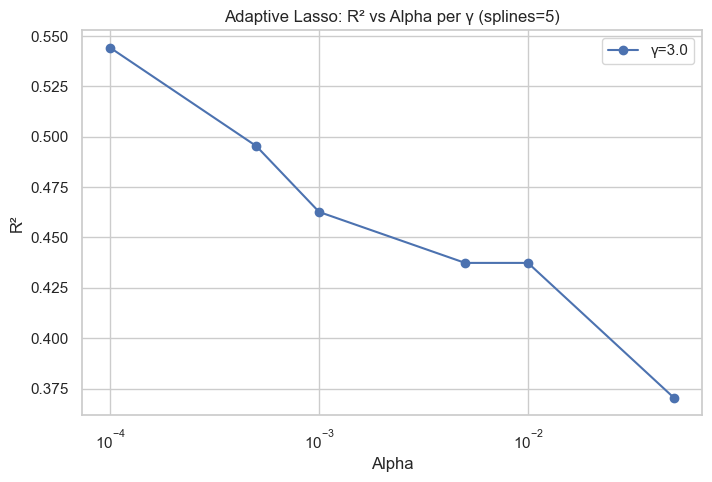

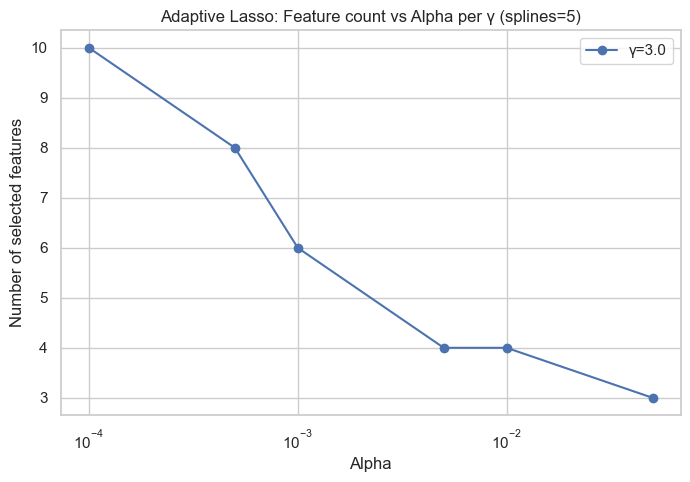

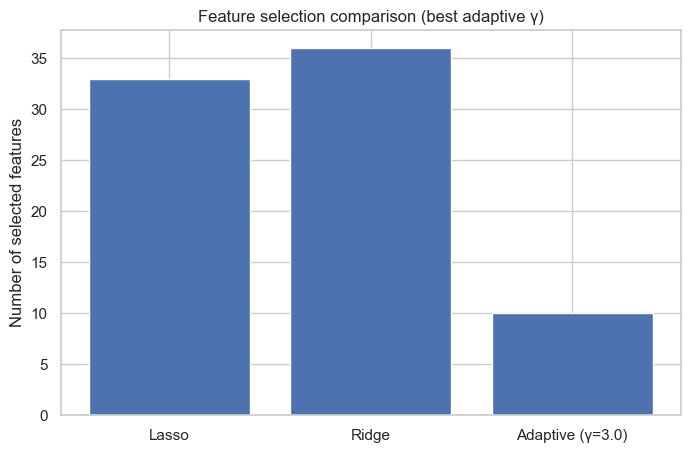

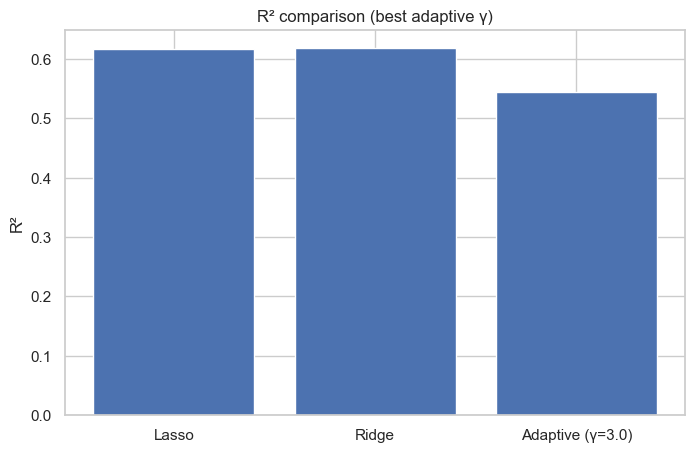

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")

#Adaptive Lasso: R² vs Alpha per gamma
plt.figure(figsize=(8,5))
for gamma in gamma_values:
    r2_values = []
    for alpha in alpha_values:
        # pick spline=5 for consistent comparison
        r2 = results["adaptive_lasso"][gamma][alpha][5]["r2"]
        r2_values.append(r2 if r2 is not None else np.nan)
    plt.plot(alpha_values, r2_values, marker='o', label=f'γ={gamma}')
plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("R²")
plt.title("Adaptive Lasso: R² vs Alpha per γ (splines=5)")
plt.legend()
plt.show()

#Adaptive Lasso: #Features vs Alpha per gamma
plt.figure(figsize=(8,5))
for gamma in gamma_values:
    n_features = []
    for alpha in alpha_values:
        n = len(results["adaptive_lasso"][gamma][alpha][5]["selected_features"])
        n_features.append(n)
    plt.plot(alpha_values, n_features, marker='o', label=f'γ={gamma}')
plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("Number of selected features")
plt.title("Adaptive Lasso: Feature count vs Alpha per γ (splines=5)")
plt.legend()
plt.show()


# COmparing adaptive lasso configeration with standard lasso and ridge
best_r2 = -np.inf
best_config = None
for gamma in gamma_values:
    for alpha in alpha_values:
        r2 = results["adaptive_lasso"][gamma][alpha][5]["r2"]
        if r2 is not None and r2 > best_r2:
            best_r2 = r2
            best_config = (gamma, alpha)

best_gamma, best_alpha = best_config
selected_adaptive = results["adaptive_lasso"][best_gamma][best_alpha][5]["selected_features"]

# Pick same spline=5 for Lasso & Ridge at same alpha
selected_lasso = results["standard_lasso"][best_alpha][5]["selected_features"]
selected_ridge = results["standard_ridge"][best_alpha][5]["selected_features"]

# Barplot: number of features
plt.figure(figsize=(8,5))
plt.bar(["Lasso", "Ridge", f"Adaptive (γ={best_gamma})"], 
        [len(selected_lasso), len(selected_ridge), len(selected_adaptive)])
plt.ylabel("Number of selected features")
plt.title("Feature selection comparison (best adaptive γ)")
plt.show()

# Barplot: R² comparison
r2_values = [
    results["standard_lasso"][best_alpha][5]["r2"],
    results["standard_ridge"][best_alpha][5]["r2"],
    results["adaptive_lasso"][best_gamma][best_alpha][5]["r2"]
]
plt.figure(figsize=(8,5))
plt.bar(["Lasso", "Ridge", f"Adaptive (γ={best_gamma})"], r2_values)
plt.ylabel("R²")
plt.title("R² comparison (best adaptive γ)")
plt.show()

